In [1]:
import numpy as np
import pandas as pd
import os
import datetime
# import pandas_profiling
import gc
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm_notebook as tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score,mean_absolute_error
from math import sqrt

from sklearn import metrics                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier

pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from multiprocessing import  Pool
from joblib import Parallel, delayed
import multiprocessing

def applyParallel(dfGrouped, func,n_jobs = 12):
    retLst = Parallel(n_jobs=n_jobs)(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst)

def parallelize_dataframe(df, func, n_cores=12):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split)).reset_index()
    pool.close()
    pool.join()
    return df

def mape(y_true, y_pred): 
    mape = (np.abs((y_true - y_pred)/(y_true))).mean()
    return mape 

def preprocessing(train,test):
    cat_cols = train.select_dtypes("object").columns
    for col in tqdm(cat_cols):
        if col in train.columns:
            train[col] = train[col].fillna("unseen").astype(str)
            test[col] = test[col].fillna("unseen").astype(str)
            le = LabelEncoder()
            le.fit(list(train[col])+list(test[col]))
            train[col] = le.transform(train[col])
            train[col] = train[col].astype("category")        
            test[col] = le.transform(test[col])
            test[col] = test[col].astype("category")         
    return train, test

def kfold_lightgbm(params, train_df, test_df, FEATS_EXCLUDED,n_estimators, LOCAL_TEST=True):
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    num_folds = 3
    folds = KFold(n_splits = num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance = pd.DataFrame()
    final_rmse = 0
    final_mape = 0
    final_mae = 0
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED+["PSGR_COUNT"]]
    clfs = []
    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['PSGR_COUNT'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['PSGR_COUNT'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['PSGR_COUNT'].iloc[valid_idx]
    
        lgb_train = lgb.Dataset(train_x,label=train_y,free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,label=valid_y,free_raw_data=False)

        reg = lgb.train(params,lgb_train,valid_sets=[lgb_train, lgb_test],valid_names=['train', 'valid'],
                        num_boost_round=n_estimators,early_stopping_rounds= 200,verbose_eval=1000)

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)

        # set data structure
        #reg = lgb.LGBMRegressor(**params, n_estimators = n_estimators)   
        #reg.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        #          eval_metric="auc",verbose=333, early_stopping_rounds=333)       
        
        #oof_preds[valid_idx] = reg.predict(valid_x)
        if LOCAL_TEST==False:
            sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        imp = pd.DataFrame()
        imp["feature"] = train_x.columns
        imp["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        imp["fold"] = n_fold + 1
        feature_importance = pd.concat([feature_importance, imp], axis=0)
         
        curr_rmse = sqrt(mean_squared_error(valid_y, oof_preds[valid_idx]))
        curr_mape = mape(valid_y, oof_preds[valid_idx]) 
        curr_mae = mean_absolute_error(valid_y, oof_preds[valid_idx])
        
        print('Fold %2d -> rmse : %.6f -- mape : %.6f -- mae : %.6f' % (n_fold + 1, curr_rmse,curr_mape,curr_mae)) 
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()
        
    final_rmse = sqrt(mean_squared_error(train_df['PSGR_COUNT'], oof_preds))
    final_mape = mape(train_df['PSGR_COUNT'], oof_preds) 
    final_mae = mean_absolute_error(train_df['PSGR_COUNT'], oof_preds)
              
    print('Overall RMSE : %.6f - Overall MAPE : %.6f - Overall MAE : %.6f' % (final_rmse,final_mape,final_mae))
        
    return sub_preds, oof_preds, feature_importance

In [3]:
def day_features(df):
    df['LEG1_DEP_DATE_GMT_MONTH'] = df['LEG1_DEP_DATE_GMT'].dt.month.astype(np.int8)
    df['LEG1_DEP_DATE_GMT_WEEK'] = df['LEG1_DEP_DATE_GMT'].dt.weekofyear.astype(np.int8)
    df['LEG1_DEP_DATE_GMT_DAYOFYEAR'] = df['LEG1_DEP_DATE_GMT'].dt.dayofyear.astype(np.int16)
    df['LEG1_DEP_DATE_GMT_DAYOFWEEK'] = df['LEG1_DEP_DATE_GMT'].dt.dayofweek.astype(np.int16)
    df['LEG1_DEP_DATE_GMT_DAYOFMONTH'] = df['LEG1_DEP_DATE_GMT'].dt.day.astype(np.int16)
    return df 

def time_features(df):
    df["LEG1_DEP_TIME_GMT_HOUR"] = df["LEG1_DEP_TIME_GMT"].apply(lambda x: int(x)//100)
    df["LEG1_DEP_TIME_GMT_MINUTE"] = df["LEG1_DEP_TIME_GMT"].apply(lambda x: int(x)%100)
    df["LEG1_DEP_DATE_GMT"] = df["LEG1_DEP_DATE_GMT"].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    df["LEG1_DEP_DATE_GMT"] = pd.to_datetime(df["LEG1_DEP_DATE_GMT"]) + pd.to_timedelta(df["LEG1_DEP_TIME_GMT_HOUR"], unit='h') + pd.to_timedelta(df["LEG1_DEP_TIME_GMT_MINUTE"], unit='m')

    df["LEG2_DEP_TIME_GMT_HOUR"] = df["LEG2_DEP_TIME_GMT"].apply(lambda x: int(x)//100)
    df["LEG2_DEP_TIME_GMT_MINUTE"] = df["LEG2_DEP_TIME_GMT"].apply(lambda x: int(x)%100)
    df["LEG2_DEP_DATE_GMT"] = df["LEG2_DEP_DATE_GMT"].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    df["LEG2_DEP_DATE_GMT"] = pd.to_datetime(df["LEG2_DEP_DATE_GMT"]) + pd.to_timedelta(df["LEG2_DEP_TIME_GMT_HOUR"], unit='h') + pd.to_timedelta(df["LEG2_DEP_TIME_GMT_MINUTE"], unit='m')

    df["LEG1_ARR_TIME_GMT_HOUR"] = df["LEG1_ARR_TIME_GMT"].apply(lambda x: int(x)//100)
    df["LEG1_ARR_TIME_GMT_MINUTE"] = df["LEG1_ARR_TIME_GMT"].apply(lambda x: int(x)%100)
    df["LEG1_ARR_DATE_GMT"] = df["LEG1_ARR_DATE_GMT"].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    df["LEG1_ARR_DATE_GMT"] = pd.to_datetime(df["LEG1_ARR_DATE_GMT"]) + pd.to_timedelta(df["LEG1_ARR_TIME_GMT_HOUR"], unit='h') + pd.to_timedelta(df["LEG1_ARR_TIME_GMT_MINUTE"], unit='m')

    df["LEG2_ARR_TIME_GMT_HOUR"] = df["LEG2_ARR_TIME_GMT"].apply(lambda x: int(x)//100)
    df["LEG2_ARR_TIME_GMT_MINUTE"] = df["LEG2_ARR_TIME_GMT"].apply(lambda x: int(x)%100)
    df["LEG2_ARR_DATE_GMT"] = df["LEG2_ARR_DATE_GMT"].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    df["LEG2_ARR_DATE_GMT"] = pd.to_datetime(df["LEG2_ARR_DATE_GMT"]) + pd.to_timedelta(df["LEG2_ARR_TIME_GMT_HOUR"], unit='h') + pd.to_timedelta(df["LEG2_ARR_TIME_GMT_MINUTE"], unit='m')
    return df

In [4]:
dtypes_dict ={}
for col in ['CARRIER', 'FLIGHT_NO', 'AIRCRAFT_TYPE', 'OND', 'OND_SELL_CLASS','LEG1_SELL_CLASS', 'OND_CABIN_CLASS',
            'LEG1_CABIN_CLASS', 'ORIGIN','HUB', 'DESTINATION']:
    dtypes_dict[col]="category"
    
train_raw = pd.read_csv("datathon_case_2/case_2_train_data.csv",dtype=dtypes_dict)
test = pd.read_csv("datathon_case_2/case_2_result.csv",dtype=dtypes_dict)
print(train_raw.shape, test.shape)

In [5]:
train = train_raw.groupby('LEG1_DEP_DATE_GMT').apply(lambda x: x.sample(frac = 0.1))
train = train.reset_index(drop=True)
train.shape

In [6]:
# sns.distplot(sample["LEG1_DEP_DATE_GMT"])
# sns.distplot(test["LEG1_DEP_DATE_GMT"])
# plt.savefig('presentation/sample_test_distribution.png')

In [7]:
# np.sqrt(mean_squared_error(train["PSGR_COUNT"], np.ones(len(train))))
# mape(train["PSGR_COUNT"], np.ones(len(train)))
# mean_absolute_error(train["PSGR_COUNT"], np.ones(len(train)))

In [8]:
# FLIGHT_NO            0.001030
# AIRCRAFT_TYPE        0.003992

In [9]:
# 1 saat/gün/hafta/ay bazında havalimanı/taşıyıcı/hub uçuş sayıları
# Bir önceki uçuştan geçen süre, Bir sonraki uçuşa kalan süre
# Uçakların min mean max yolcu sayıları

In [10]:
train = parallelize_dataframe(df = train, func = time_features)
test = parallelize_dataframe(df = test, func = time_features)

In [11]:
# train.to_pickle('train_sample.pkl')
# test.to_pickle('test_sample.pkl')

## Feature Engineering

In [5]:
train = pd.read_pickle('train_sample.pkl')
test = pd.read_pickle('test_sample.pkl')    
print('Shape control:', train.shape, test.shape)

Shape control: (9056281, 31) (100000, 31)


In [6]:
train["FLIGHT_NO"] = train["FLIGHT_NO"].astype(str).fillna("UNSEEN").astype("category")
train["AIRCRAFT_TYPE"] = train["AIRCRAFT_TYPE"].astype(str).fillna("UNSEEN").astype("category")

test["FLIGHT_NO"] = test["FLIGHT_NO"].astype(str).fillna("UNSEEN").astype("category")
test["AIRCRAFT_TYPE"] = test["AIRCRAFT_TYPE"].astype(str).fillna("UNSEEN").astype("category")

In [7]:
train["OND_ALL"] = (train["ORIGIN"].astype("str")+train["HUB"].astype(str)+train["DESTINATION"].astype(str)).astype("category")
test["OND_ALL"] = (test["ORIGIN"].astype("str")+test["HUB"].astype(str)+test["DESTINATION"].astype(str)).astype("category")

In [8]:
cat_cols = ['CARRIER', 'FLIGHT_NO', 'AIRCRAFT_TYPE', 'OND', 'OND_SELL_CLASS','LEG1_SELL_CLASS',
            'OND_CABIN_CLASS', 'LEG1_CABIN_CLASS', 'ORIGIN','HUB', 'DESTINATION']

cat_cols.append("OND_ALL")

In [9]:
train[cat_cols].nunique().reset_index().sort_values(0)

,index,0
6,OND_CABIN_CLASS,5
7,LEG1_CABIN_CLASS,5
5,LEG1_SELL_CLASS,30
4,OND_SELL_CLASS,31
0,CARRIER,78
2,AIRCRAFT_TYPE,148
9,HUB,955
10,DESTINATION,2039
8,ORIGIN,2509
1,FLIGHT_NO,9981


In [10]:
train[cat_cols].nunique().reset_index().sort_values(0)["index"].tolist()

['OND_CABIN_CLASS',
 'LEG1_CABIN_CLASS',
 'LEG1_SELL_CLASS',
 'OND_SELL_CLASS',
 'CARRIER',
 'AIRCRAFT_TYPE',
 'HUB',
 'DESTINATION',
 'ORIGIN',
 'FLIGHT_NO',
 'OND',
 'OND_ALL']

### Fligt Time

In [11]:
train["LEG1_DURATION"] = ((train["LEG1_ARR_DATE_GMT"] - train["LEG1_DEP_DATE_GMT"])/np.timedelta64(60, 's')).astype(int)
train["LEG2_DURATION"] = ((train["LEG2_ARR_DATE_GMT"] - train["LEG2_DEP_DATE_GMT"])/np.timedelta64(60, 's')).astype(int)
train["LEG_DURATION"] = ((train["LEG2_ARR_DATE_GMT"] - train["LEG1_DEP_DATE_GMT"])/np.timedelta64(60, 's')).astype(int)

In [12]:
train = day_features(train)

In [12]:
# for col in tqdm(['CARRIER','AIRCRAFT_TYPE', 'HUB', 'DESTINATION','ORIGIN','FLIGHT_NO']):
#     train[col+"_lagdep1"] = (train.groupby(col)["LEG2_DEP_DATE_GMT"].diff()/np.timedelta64(60, 's')).astype(float)
#     train[col+"_leaddep1"] = -1*(train.groupby(col)["LEG2_DEP_DATE_GMT"].diff(-1)/np.timedelta64(60, 's')).astype(float)  

### Aggregations

In [13]:
# HUBFLIGHT_NO_nunique
# DESTINATIONORIGIN_nunique	13.537768
# # LEG1_ARR_TIME_GMT_HOUR	13.391553
# # ORIGINOND_nunique	13.080300
# # CARRIERHUB_nunique	13.026749
# DESTINATIONFLIGHT_NO_nunique	13.024159

In [13]:
df = pd.concat([train[cat_cols],test[cat_cols]])

In [14]:
col1 = "HUB"
col2 = "FLIGHT_NO"
temp = df[[col1,col2]].copy()
temp = temp.groupby([col1])[col2].agg(["nunique"]).reset_index().rename({"nunique":col1+"_"+col2+"_nunique"},axis = 1)
train = train.merge(temp,"left",col1)

In [15]:
col1 = "DESTINATION"
col2 = "ORIGIN"
temp = df[[col1,col2]].copy()
temp = temp.groupby([col1])[col2].agg(["nunique"]).reset_index().rename({"nunique":col1+"_"+col2+"_nunique"},axis = 1)
train = train.merge(temp,"left",col1)

In [16]:
col1 = "DESTINATION"
col2 = "FLIGHT_NO"
temp = df[[col1,col2]].copy()
temp = temp.groupby([col1])[col2].agg(["nunique"]).reset_index().rename({"nunique":col1+"_"+col2+"_nunique"},axis = 1)
train = train.merge(temp,"left",col1)

In [17]:
for col in ['HUB', 'DESTINATION']:
    train[col] = train[col].astype("category")

### Numeric

In [19]:
# aggs = {}
# main_col = "LEG_DURATION"
# for col in tqdm(["LEG1_SELL_CLASS","OND_SELL_CLASS"]):
#     for agg in ['mean','std']:
#         train[col+"_"+main_col+"_"+agg] = train.groupby(col)[main_col].transform(agg)

A Jupyter Widget

In [ ]:
# aggs = {}
# main_col = "LEG_DURATION"
# for col in tqdm(["LEG1_SELL_CLASS","OND_SELL_CLASS"]):
#     for agg in ['mean','std']:
#         train[col+"_"+main_col+"_"+agg] = train.groupby(col)[main_col].transform(agg)

In [40]:
# for col in tqdm(['DESTINATION','ORIGIN','HUB']):
#     train[col+"_lagdep1"] = (train.groupby(col)["LEG1_DEP_DATE_GMT"].diff()/np.timedelta64(60, 's')).astype(float).fillna(999999)
#     train[col+"_leaddep1"] = -1*(train.groupby(col)["LEG1_DEP_DATE_GMT"].diff(-1)/np.timedelta64(60, 's')).astype(float).fillna(999999)

A Jupyter Widget

### Target and Frequency Encoding

In [18]:
#Frequency of Categorical values
for col in tqdm(['CARRIER', 'FLIGHT_NO', 'AIRCRAFT_TYPE', 'OND', 'ORIGIN','HUB', 'DESTINATION','OND_ALL']):
    freq_dict = pd.concat([train[col],test[col]]).value_counts().to_dict()
    train[col+"_FREQ"] = train[col].map(freq_dict)
    test[col+"_FREQ"] = test[col].map(freq_dict)
    
    agg_opts = ['mean']
    agg_dict = train.groupby(col).agg({'PSGR_COUNT':agg_opts}).to_dict()
    for opt in agg_opts:
        train[col+"_"+opt] = train[col].map(agg_dict[('PSGR_COUNT', opt)])
        test[col+"_"+opt] = test[col].map(agg_dict[('PSGR_COUNT', opt)])

A Jupyter Widget

### Model

In [32]:
train_df = train.copy()
test_df = test.copy()

In [26]:
# FEATS_EXCLUDED = ["ID_REC","LEG1_DEP_DATE_GMT","LEG1_ARR_DATE_GMT","LEG2_DEP_DATE_GMT","LEG2_ARR_DATE_GMT","LEG1_DEP_TIME_GMT",
#                   "LEG1_DEP_TIME_GMT","LEG1_ARR_TIME_GMT","LEG2_DEP_TIME_GMT","LEG2_ARR_TIME_GMT"]

# for col in FEATS_EXCLUDED:
#     if col in train_df:
#         del train_df[col], test_df[col]
        
# gc.collect()

41

In [33]:
FEATS_EXCLUDED = ["ID_REC","LEG1_DEP_DATE_GMT","LEG1_ARR_DATE_GMT","LEG2_DEP_DATE_GMT","LEG2_ARR_DATE_GMT","LEG1_DEP_TIME_GMT",
                  "LEG1_DEP_TIME_GMT","LEG1_ARR_TIME_GMT","LEG2_DEP_TIME_GMT","LEG2_ARR_TIME_GMT",
                  'CARRIER', 'FLIGHT_NO', 'AIRCRAFT_TYPE', 'OND', 'ORIGIN','HUB', 'DESTINATION','OND_ALL']
for col in FEATS_EXCLUDED:
    if col in train:
        del train[col], test[col]
        
gc.collect()

45

In [21]:
# for col in tqdm(['FLIGHT_NO', 'OND', 'OND_ALL']):
#     if col in train_df.columns:
#         le = LabelEncoder()
#         le.fit(list(train_df[col])+list(test_df[col]))
#         train_df[col] = le.transform(train_df[col])
#         test_df[col] = le.transform(test_df[col])

A Jupyter Widget

In [28]:
# for col in ['OND_CABIN_CLASS', 'LEG1_CABIN_CLASS', 'LEG1_SELL_CLASS', 'OND_SELL_CLASS']:
#     train_df[col] = train_df[col].astype("category")
#     test_df[col] = test_df[col].astype("category")

In [21]:
# train_df, test_df = preprocessing(train_df,test_df)

In [34]:
params = {'objective': 'regression','metric': 'rmse','learning_rate': 0.05,'verbose': -1,'nthread':32,
          'num_leaves': 10, 'min_data': 50, 'max_depth': 10, 'num_leaves': 31, 'min_data_in_leaf': 50, 'feature_fraction': 0.8,'bagging_fraction': 0.8}

sub_preds, oof_preds, feature_importance = kfold_lightgbm(params,train_df,test_df,FEATS_EXCLUDED,9999)

Starting LightGBM. Train shape: (9056281, 61)
Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 2.49323	valid's rmse: 2.55105
[2000]	train's rmse: 2.43495	valid's rmse: 2.53459
[3000]	train's rmse: 2.39275	valid's rmse: 2.52617
[4000]	train's rmse: 2.35795	valid's rmse: 2.52054
[5000]	train's rmse: 2.32936	valid's rmse: 2.51684
[6000]	train's rmse: 2.30485	valid's rmse: 2.51455
[7000]	train's rmse: 2.28225	valid's rmse: 2.51275
[8000]	train's rmse: 2.26214	valid's rmse: 2.51148
[9000]	train's rmse: 2.24355	valid's rmse: 2.51054
Did not meet early stopping. Best iteration is:
[9999]	train's rmse: 2.22523	valid's rmse: 2.50957
Fold  1 -> rmse : 2.509573 -- mape : 0.607282 -- mae : 1.147738
Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 2.48857	valid's rmse: 2.55298
[2000]	train's rmse: 2.43331	valid's rmse: 2.53781
[3000]	train's rmse: 2.39055	valid's rmse: 2.52947
[4000]	train's rmse: 2.35605	valid's rmse: 2.52442
[5

In [35]:
feature_importance.groupby("feature")["importance"].agg("mean").reset_index().sort_values("importance",ascending=False)

,feature,importance
36,OND_ALL_mean,18.072544
28,LEG1_SELL_CLASS,17.196183
40,OND_mean,16.634963
39,OND_SELL_CLASS,16.450000
5,CARRIER_mean,16.020593
3,CARRIER_LEG_DURATION_mean,15.934079
35,OND_ALL_FREQ,15.598502
22,LEG1_DEP_DATE_GMT_DAYOFYEAR,15.598253
6,CONNECTION_TIME,15.511586
13,FLIGHT_NO_mean,15.426707


In [36]:
oof_preds1 = np.where(oof_preds<1,1,oof_preds)
sub_preds1 = np.where(sub_preds<1,1,sub_preds)
final_rmse = sqrt(mean_squared_error(train_df['PSGR_COUNT'], oof_preds1))
final_mape = mape(train_df['PSGR_COUNT'], oof_preds1) 
final_mae = mean_absolute_error(train_df['PSGR_COUNT'], oof_preds1)
print('Final rmse : %.6f -- mape : %.6f -- mae : %.6f' % (final_rmse,final_mape,final_mae)) 

Final rmse : 2.517732 -- mape : 0.605513 -- mae : 1.147082


In [ ]:
# 26 Features 3 Fold Final rmse : 2.628596 -- mape : 0.649741 -- mae : 1.211657
# 31 Features 3 Fold Final rmse : 2.623387 -- mape : 0.647424 -- mae : 1.208084
# 34 Features + drop neg connection Final rmse : 2.620878 -- mape : 0.646605 -- mae : 1.207204 

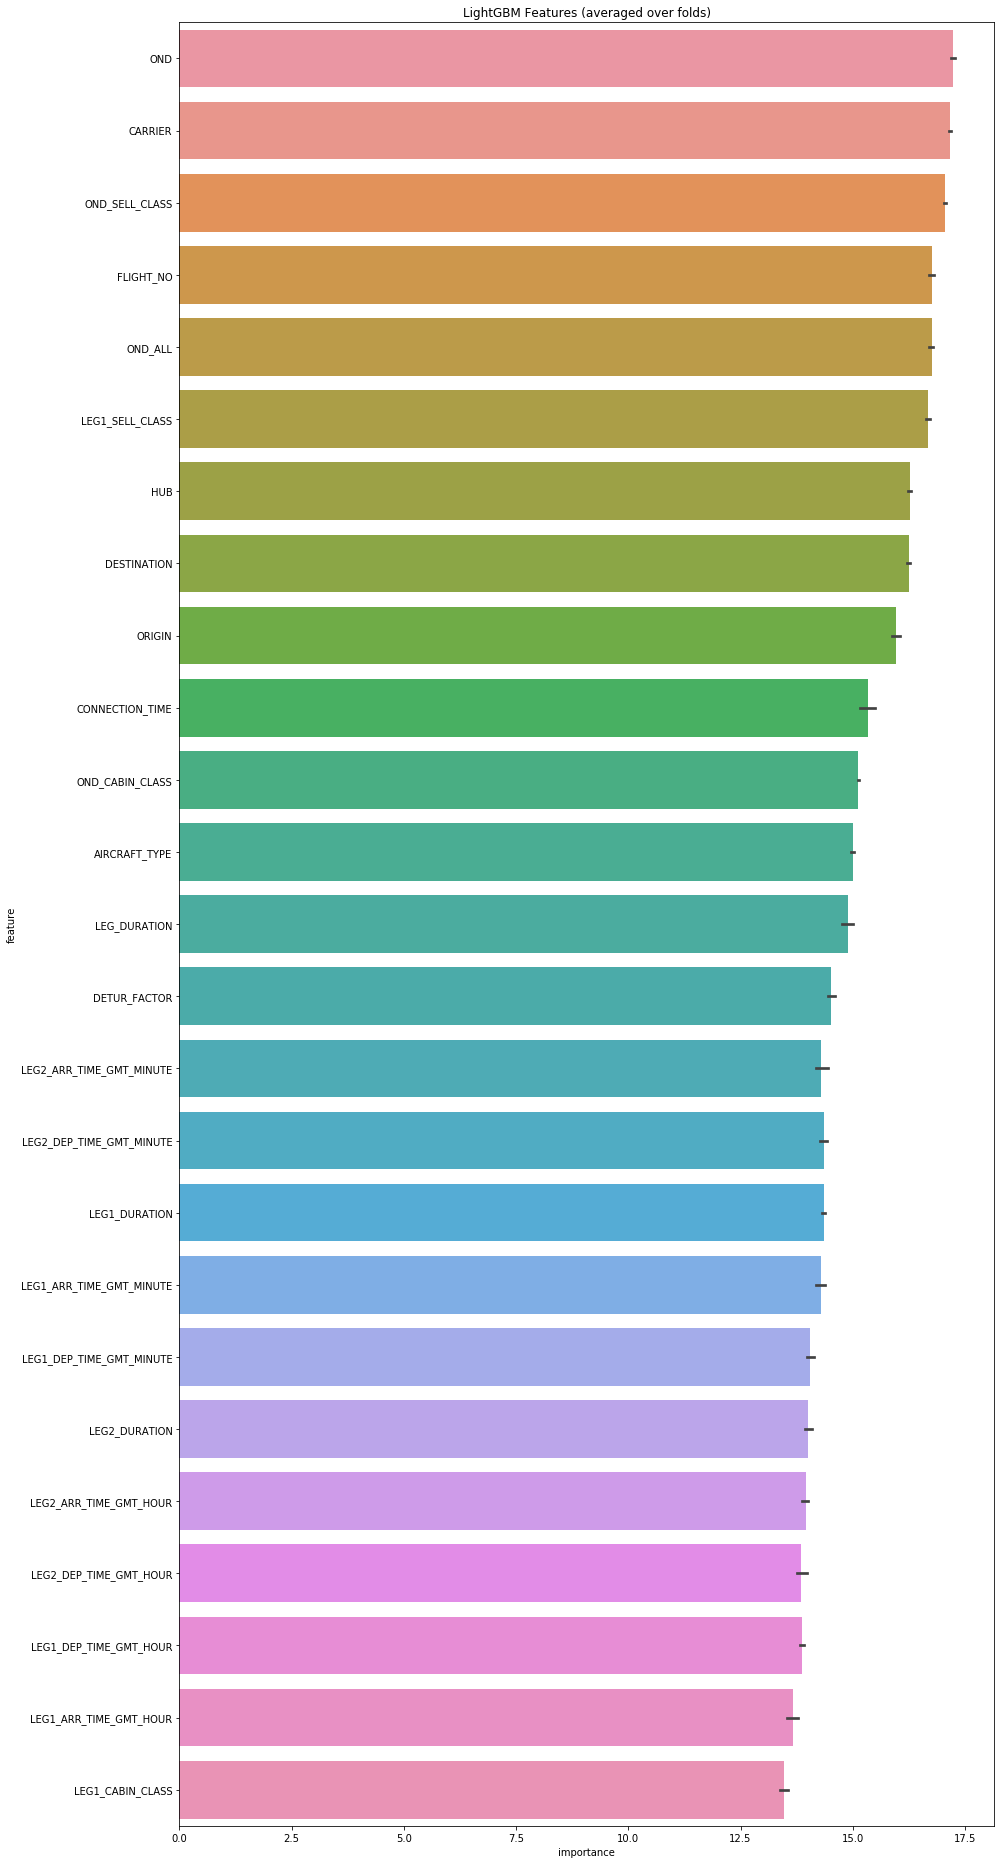

In [43]:
cols = (feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:33].index)
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('presentation/lgbm_base_importances.png')

In [24]:
mean_cols = [col for col in train.columns if "_mean" in col]
temp = train[mean_cols].copy()
temp.columns = [col.split("_")[0] for col in mean_cols]

In [27]:
for col in ["PSGR_COUNT","CONNECTION_TIME","DETUR_FACTOR","LEG1_DURATION","LEG2_DURATION","LEG_DURATION"]:
    temp[col] = train[col]
    mean_cols.append(col)

In [32]:
temp.head()

,CARRIER,FLIGHT,AIRCRAFT,OND,ORIGIN,HUB,DESTINATION,OND,PSGR_COUNT,CONNECTION_TIME,DETUR_FACTOR,LEG1_DURATION,LEG2_DURATION,LEG_DURATION
0,2.123311,2.565012,2.805818,3.423905,2.376058,2.129927,2.772722,3.881579,9,215,1.070729,570,410,1195
1,1.734697,2.056361,1.755380,1.812500,1.813594,1.748878,1.447406,1.923077,1,148,1.030264,215,119,482
2,1.734697,1.995421,1.877482,1.595238,1.679884,1.689866,1.957906,2.000000,2,176,1.080443,145,131,452
3,2.131159,2.133593,2.350909,1.000000,3.033579,2.128613,1.856075,1.000000,1,445,1.255491,380,175,1000
4,1.787854,2.299859,2.110610,2.517241,2.268076,1.847002,1.743842,2.666667,2,49,1.025506,157,179,385


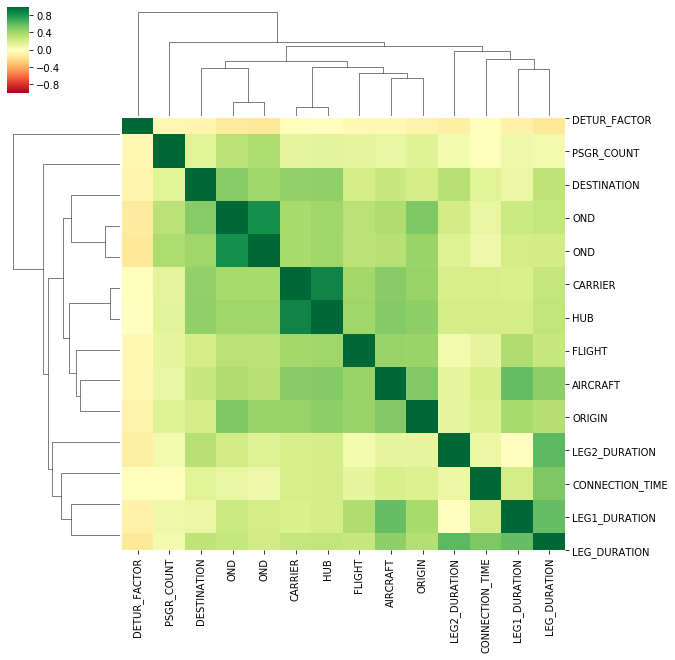

In [33]:
kw_cbar = {'vmax':1, 'vmin':-1, 'cmap': 'RdYlGn'}
corr = temp.corr('spearman')
sns.clustermap(corr, **kw_cbar)

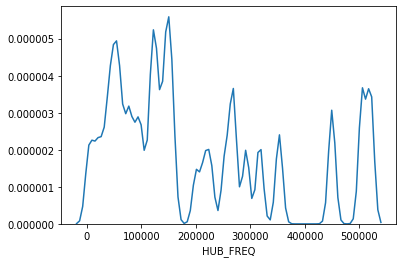

In [31]:
sns.set_style(None)
sns.distplot(train["HUB_FREQ"],hist=False)
plt.savefig("presentation/frequency_encoding.png")

### Negative Connection Time

In [35]:
def lgbm_fit(x_train, y_train, x_valid, y_valid):    
    params = {'objective': 'regression','metric': 'rmse','learning_rate': 0.05,'verbose': -1,'nthread':32,
          'num_leaves': 10, 'min_data': 50, 'max_depth': 10, 'num_leaves': 31, 'min_data_in_leaf': 50, 'feature_fraction': 0.8,'bagging_fraction': 0.8}
    lgb_train = lgb.Dataset(x_train,label=y_train,free_raw_data=False)
    lgb_test = lgb.Dataset(x_valid,label=y_valid,free_raw_data=False)

    model = lgb.train(params,lgb_train,valid_sets=[lgb_train, lgb_test],valid_names=['train', 'valid'],
                      num_boost_round=1000,early_stopping_rounds= 200,verbose_eval=333)

    return model

In [28]:
temp = train[train["CONNECTION_TIME"]<0].copy()
temp.shape

(174113, 43)

In [31]:
temp["CONNECTION_TIME"].describe()

count    174113.000000
mean        -28.815488
std         115.785432
min       -2844.000000
25%         -20.000000
50%         -12.000000
75%          -6.000000
max          -1.000000
Name: CONNECTION_TIME, dtype: float64

In [30]:
test[test["CONNECTION_TIME"]<0].shape

(1837, 32)

In [33]:
for i in range(1,25):
    print(col,i,np.percentile(temp["CONNECTION_TIME"],i))

LEG2_ARR_TIME_GMT 1 -696.0
LEG2_ARR_TIME_GMT 2 -85.0
LEG2_ARR_TIME_GMT 3 -55.0
LEG2_ARR_TIME_GMT 4 -45.0
LEG2_ARR_TIME_GMT 5 -40.0
LEG2_ARR_TIME_GMT 6 -37.0
LEG2_ARR_TIME_GMT 7 -35.0
LEG2_ARR_TIME_GMT 8 -35.0
LEG2_ARR_TIME_GMT 9 -32.0
LEG2_ARR_TIME_GMT 10 -30.0
LEG2_ARR_TIME_GMT 11 -30.0
LEG2_ARR_TIME_GMT 12 -30.0
LEG2_ARR_TIME_GMT 13 -29.0
LEG2_ARR_TIME_GMT 14 -28.0
LEG2_ARR_TIME_GMT 15 -26.0
LEG2_ARR_TIME_GMT 16 -25.0
LEG2_ARR_TIME_GMT 17 -25.0
LEG2_ARR_TIME_GMT 18 -25.0
LEG2_ARR_TIME_GMT 19 -25.0
LEG2_ARR_TIME_GMT 20 -24.0
LEG2_ARR_TIME_GMT 21 -23.0
LEG2_ARR_TIME_GMT 22 -22.0
LEG2_ARR_TIME_GMT 23 -21.0
LEG2_ARR_TIME_GMT 24 -20.0


In [37]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df,train_df["PSGR_COUNT"],train_size = 0.67,shuffle=True)
del x_train["PSGR_COUNT"], x_valid["PSGR_COUNT"]
gc.collect()
x_train = x_train[x_train["CONNECTION_TIME"] >= -20]
y_train = y_train[y_train.index.isin(x_train.index)]

model = lgbm_fit(x_train, y_train, x_valid, y_valid)

Training until validation scores don't improve for 200 rounds.
[333]	train's rmse: 2.60315	valid's rmse: 2.68041
[666]	train's rmse: 2.56437	valid's rmse: 2.66658
[999]	train's rmse: 2.539	valid's rmse: 2.65885
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 2.53898	valid's rmse: 2.65885


In [62]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df,train_df["PSGR_COUNT"],train_size = 0.67,shuffle=True)
del x_train["PSGR_COUNT"], x_valid["PSGR_COUNT"]
gc.collect()

model = lgbm_fit(x_train, y_train, x_valid, y_valid)

Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 2.62436	valid's rmse: 2.69139
[400]	train's rmse: 2.59282	valid's rmse: 2.67602
[600]	train's rmse: 2.57061	valid's rmse: 2.66708
[800]	train's rmse: 2.55427	valid's rmse: 2.66177
[1000]	train's rmse: 2.53892	valid's rmse: 2.65686
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 2.53892	valid's rmse: 2.65686


In [65]:
x_train = x_train[x_train["CONNECTION_TIME"] >= 0]
y_train = y_train[y_train.index.isin(x_train.index)]

model = lgbm_fit(x_train, y_train, x_valid, y_valid)

Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 2.63286	valid's rmse: 2.6923
[400]	train's rmse: 2.60135	valid's rmse: 2.67716
[600]	train's rmse: 2.57887	valid's rmse: 2.66838
[800]	train's rmse: 2.56035	valid's rmse: 2.66201
[1000]	train's rmse: 2.54485	valid's rmse: 2.65693
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 2.54485	valid's rmse: 2.65693


In [66]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df,train_df["PSGR_COUNT"],train_size = 0.67,shuffle=True)
del x_train["PSGR_COUNT"], x_valid["PSGR_COUNT"]
gc.collect()
x_train = x_train[x_train["CONNECTION_TIME"] >= -33]
y_train = y_train[y_train.index.isin(x_train.index)]

model = lgbm_fit(x_train, y_train, x_valid, y_valid)

Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 2.63067	valid's rmse: 2.67108
[400]	train's rmse: 2.60025	valid's rmse: 2.65762
[600]	train's rmse: 2.57588	valid's rmse: 2.64881
[800]	train's rmse: 2.55793	valid's rmse: 2.6431
[1000]	train's rmse: 2.54259	valid's rmse: 2.63946
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 2.54259	valid's rmse: 2.63946


In [34]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df,train_df["PSGR_COUNT"],train_size = 0.67,shuffle=True)
del x_train["PSGR_COUNT"], x_valid["PSGR_COUNT"]
gc.collect()
x_train = x_train[x_train["CONNECTION_TIME"] >= -100]
y_train = y_train[y_train.index.isin(x_train.index)]

model = lgbm_fit(x_train, y_train, x_valid, y_valid)

Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 2.54462	valid's rmse: 2.63991
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 2.54462	valid's rmse: 2.63991


In [36]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df,train_df["PSGR_COUNT"],train_size = 0.67,shuffle=True)
del x_train["PSGR_COUNT"], x_valid["PSGR_COUNT"]
gc.collect()
x_train = x_train[x_train["CONNECTION_TIME"] >= -55]
y_train = y_train[y_train.index.isin(x_train.index)]

model = lgbm_fit(x_train, y_train, x_valid, y_valid)

Training until validation scores don't improve for 200 rounds.
[333]	train's rmse: 2.60418	valid's rmse: 2.66382
[666]	train's rmse: 2.5692	valid's rmse: 2.65015
[999]	train's rmse: 2.54211	valid's rmse: 2.6403
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 2.54208	valid's rmse: 2.64029


In [38]:
x_train, x_valid, y_train, y_valid = train_test_split(train_df,train_df["PSGR_COUNT"],train_size = 0.67,shuffle=True)
del x_train["PSGR_COUNT"], x_valid["PSGR_COUNT"]
gc.collect()
x_train = x_train[x_train["CONNECTION_TIME"] >= -40]
y_train = y_train[y_train.index.isin(x_train.index)]

model = lgbm_fit(x_train, y_train, x_valid, y_valid)

Training until validation scores don't improve for 200 rounds.
[333]	train's rmse: 2.60836	valid's rmse: 2.6665
[666]	train's rmse: 2.57422	valid's rmse: 2.65261
[999]	train's rmse: 2.54653	valid's rmse: 2.64354
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 2.54648	valid's rmse: 2.64352


### Correlation

In [84]:
def corr_count(corr_result):
    count_zero = corr_result[["level_0"]].append(corr_result[["level_1"]].rename({"level_1":"level_0"},axis=1))
    count_zero = count_zero.level_0.value_counts().reset_index().rename({"index":"level_0","level_0":"count_0"},axis=1)
    count_one = corr_result[["level_1"]].append(corr_result[["level_0"]].rename({"level_0":"level_1"},axis=1))
    count_one = count_one.level_1.value_counts().reset_index().rename({"index":"level_1","level_1":"count_1"},axis=1)
    corr_result = corr_result.merge(count_zero,"left","level_0").merge(count_one,"left","level_1")
    return corr_result

def corr_eliminate(corr_result,k):
    import random
    corr_cols = []
    corr_temp = corr_count(corr_result)
    while corr_temp["correlation"].max()>k:
        if corr_temp.iloc[0,3] > corr_temp.iloc[0,4]:
            corr_cols.append(corr_temp.iloc[0,0])
        elif corr_temp.iloc[0,3] < corr_temp.iloc[0,4]:
            corr_cols.append(corr_temp.iloc[0,1])
        else:
            corr_cols.append(corr_temp.iloc[0,random.randint(0,1)])
        corr_temp = corr_temp[(corr_temp.level_0.isin(corr_cols)==False)&(corr_temp.level_1.isin(corr_cols)==False)]
        corr_temp = corr_count(corr_temp)

    return corr_cols

### corr_result = pd.read_csv("output/corr_result.csv")
### corr_result = corr_result[corr_result.correlation<1]

df = pd.concat([train,test],axis=0)

for col in FEATS_EXCLUDED+["PSGR_COUNT"]:
    if col in df:
        del df[col]
        
corr_matrix = df.corr().abs()
corr = corr_matrix.unstack().sort_values(kind = "quicksort")
del corr_matrix
gc.collect()
corr = pd.DataFrame(data=corr,columns = ['correlation'])
corr = corr[(corr.correlation > 0.7)&(corr.correlation < 1)].reset_index()
corr_result = corr.drop_duplicates(subset=['correlation']).sort_values("correlation", ascending = False)
del corr
gc.collect()    

0

In [85]:
corr_result

,level_0,level_1,correlation
6,LEG1_DEP_DATE_GMT_MONTH,LEG1_DEP_DATE_GMT_DAYOFYEAR,0.996365
4,LEG1_DEP_DATE_GMT_WEEK,LEG1_DEP_DATE_GMT_DAYOFYEAR,0.988124
2,LEG1_DEP_DATE_GMT_MONTH,LEG1_DEP_DATE_GMT_WEEK,0.985451
0,DESTINATION_ORIGIN_nunique,DESTINATION_FLIGHT_NO_nunique,0.943208


In [ ]:
corr_cols = corr_eliminate(corr_result,0.9999)
del corr_result
del df
gc.collect()

### Versions

In [39]:
feature_importance.groupby("feature")["importance"].agg("mean").reset_index().sort_values("importance",ascending=False)

,feature,importance
20,OND,17.231087
1,CARRIER,17.170881
23,OND_SELL_CLASS,17.057945
5,FLIGHT_NO,16.772280
21,OND_ALL,16.761809
13,LEG1_SELL_CLASS,16.680160
6,HUB,16.268339
3,DESTINATION,16.249628
24,ORIGIN,15.968956
2,CONNECTION_TIME,15.328204


In [40]:
oof_preds1 = np.where(oof_preds<1,1,oof_preds)
sub_preds1 = np.where(sub_preds<1,1,sub_preds)
final_rmse = sqrt(mean_squared_error(train_df['PSGR_COUNT'], oof_preds1))
final_mape = mape(train_df['PSGR_COUNT'], oof_preds1) 
final_mae = mean_absolute_error(train_df['PSGR_COUNT'], oof_preds1)
print('Final rmse : %.6f -- mape : %.6f -- mae : %.6f' % (final_rmse,final_mape,final_mae)) 

Final rmse : 2.628596 -- mape : 0.649741 -- mae : 1.211657


In [48]:
params = {'objective': 'regression','metric': 'rmse','learning_rate': 0.05,'verbose': -1,'nthread':32,
          'num_leaves': 10, 'min_data': 50, 'max_depth': 10, 'num_leaves': 31, 'min_data_in_leaf': 50, 'feature_fraction': 0.8,'bagging_fraction': 0.8}

sub_preds, oof_preds, feature_importance = kfold_lightgbm(params,train_df,test_df,FEATS_EXCLUDED,9999)

Starting LightGBM. Train shape: (9056281, 31)
Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 2.54333	valid's rmse: 2.64421
[2000]	train's rmse: 2.48924	valid's rmse: 2.63194
[3000]	train's rmse: 2.44635	valid's rmse: 2.62592
[4000]	train's rmse: 2.4125	valid's rmse: 2.62196
[5000]	train's rmse: 2.38733	valid's rmse: 2.62005
[6000]	train's rmse: 2.36654	valid's rmse: 2.61858
[7000]	train's rmse: 2.34837	valid's rmse: 2.61782
[8000]	train's rmse: 2.33134	valid's rmse: 2.61711
Early stopping, best iteration is:
[8036]	train's rmse: 2.33064	valid's rmse: 2.61704
Fold  1 -> rmse : 2.617041 -- mape : 0.649138 -- mae : 1.208753
Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 2.54225	valid's rmse: 2.64764
[2000]	train's rmse: 2.4788	valid's rmse: 2.63251
[3000]	train's rmse: 2.43705	valid's rmse: 2.62612
[4000]	train's rmse: 2.41097	valid's rmse: 2.62361
[5000]	train's rmse: 2.38584	valid's rmse: 2.62165
Early stopping, b

In [52]:
feature_importance.groupby("feature")["importance"].agg("mean").reset_index().sort_values("importance",ascending=False)

,feature,importance
25,OND,17.389248
1,CARRIER,17.120615
28,OND_SELL_CLASS,17.057693
26,OND_ALL,16.935915
18,LEG1_SELL_CLASS,16.829299
5,FLIGHT_NO,16.762063
6,HUB,16.428159
3,DESTINATION,16.146635
29,ORIGIN,15.919302
12,LEG1_DEP_DATE_GMT_DAYOFYEAR,15.462738


In [53]:
oof_preds1 = np.where(oof_preds<1,1,oof_preds)
sub_preds1 = np.where(sub_preds<1,1,sub_preds)
final_rmse = sqrt(mean_squared_error(train_df['PSGR_COUNT'], oof_preds1))
final_mape = mape(train_df['PSGR_COUNT'], oof_preds1) 
final_mae = mean_absolute_error(train_df['PSGR_COUNT'], oof_preds1)
print('Final rmse : %.6f -- mape : %.6f -- mae : %.6f' % (final_rmse,final_mape,final_mae)) 

Final rmse : 2.623387 -- mape : 0.647424 -- mae : 1.208084


In [44]:
params = {'objective': 'regression','metric': 'rmse','learning_rate': 0.05,'verbose': -1,'nthread':32,
          'num_leaves': 10, 'min_data': 50, 'max_depth': 10, 'num_leaves': 31, 'min_data_in_leaf': 50, 'feature_fraction': 0.8,'bagging_fraction': 0.8}

sub_preds, oof_preds, feature_importance = kfold_lightgbm(params,train_df,test_df,FEATS_EXCLUDED,9999)

Starting LightGBM. Train shape: (9056281, 34)
Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 2.5471	valid's rmse: 2.64444
[2000]	train's rmse: 2.48783	valid's rmse: 2.63161
[3000]	train's rmse: 2.44821	valid's rmse: 2.62628
[4000]	train's rmse: 2.41631	valid's rmse: 2.62272
[5000]	train's rmse: 2.39256	valid's rmse: 2.62005
[6000]	train's rmse: 2.37185	valid's rmse: 2.61897
[7000]	train's rmse: 2.35146	valid's rmse: 2.61827
Early stopping, best iteration is:
[7292]	train's rmse: 2.34486	valid's rmse: 2.61759
Fold  1 -> rmse : 2.617586 -- mape : 0.649340 -- mae : 1.208630
Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 2.54217	valid's rmse: 2.64647
[2000]	train's rmse: 2.48015	valid's rmse: 2.63239
[3000]	train's rmse: 2.44104	valid's rmse: 2.62646
[4000]	train's rmse: 2.41393	valid's rmse: 2.62373
[5000]	train's rmse: 2.39048	valid's rmse: 2.62084
[6000]	train's rmse: 2.37102	valid's rmse: 2.6193
[7000]	train's rm

In [ ]:
# 26 Features 3 Fold Final rmse : 2.628596 -- mape : 0.649741 -- mae : 1.211657
# 31 Features 3 Fold Final rmse : 2.623387 -- mape : 0.647424 -- mae : 1.208084
# 34 Features + drop neg connection Final rmse : 2.620878 -- mape : 0.646605 -- mae : 1.207204 

In [45]:
train_df = train_df[train_df["CONNECTION_TIME"]>-33]

In [46]:
params = {'objective': 'regression','metric': 'rmse','learning_rate': 0.05,'verbose': -1,'nthread':32,
          'num_leaves': 10, 'min_data': 50, 'max_depth': 10, 'num_leaves': 31, 'min_data_in_leaf': 50, 'feature_fraction': 0.8,'bagging_fraction': 0.8}

sub_preds, oof_preds, feature_importance = kfold_lightgbm(params,train_df,test_df,FEATS_EXCLUDED,9999)

Starting LightGBM. Train shape: (9041020, 34)
Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 2.54119	valid's rmse: 2.63692
[2000]	train's rmse: 2.4827	valid's rmse: 2.62413
[3000]	train's rmse: 2.4418	valid's rmse: 2.61635
[4000]	train's rmse: 2.41241	valid's rmse: 2.61277
[5000]	train's rmse: 2.39239	valid's rmse: 2.61094
[6000]	train's rmse: 2.37314	valid's rmse: 2.60915
[7000]	train's rmse: 2.35573	valid's rmse: 2.60814
[8000]	train's rmse: 2.33793	valid's rmse: 2.60725
Early stopping, best iteration is:
[8046]	train's rmse: 2.33741	valid's rmse: 2.60721
Fold  1 -> rmse : 2.607213 -- mape : 0.648620 -- mae : 1.209842
Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 2.53563	valid's rmse: 2.65648
[2000]	train's rmse: 2.4788	valid's rmse: 2.64372
[3000]	train's rmse: 2.43693	valid's rmse: 2.6366
[4000]	train's rmse: 2.40596	valid's rmse: 2.633
[5000]	train's rmse: 2.38302	valid's rmse: 2.63069
[6000]	train's rmse: 

In [47]:
feature_importance.groupby("feature")["importance"].agg("mean").reset_index().sort_values("importance",ascending=False)

,feature,importance
28,OND,17.387573
31,OND_SELL_CLASS,17.060428
1,CARRIER,17.004073
29,OND_ALL,16.903587
21,LEG1_SELL_CLASS,16.782648
7,FLIGHT_NO,16.740113
8,HUB,16.600773
3,DESTINATION,16.282493
32,ORIGIN,15.958717
15,LEG1_DEP_DATE_GMT_DAYOFYEAR,15.472485


In [59]:
oof_preds1 = np.where(oof_preds<1,1,oof_preds)
sub_preds1 = np.where(sub_preds<1,1,sub_preds)
final_rmse = sqrt(mean_squared_error(train_df['PSGR_COUNT'], oof_preds1))
final_mape = mape(train_df['PSGR_COUNT'], oof_preds1) 
final_mae = mean_absolute_error(train_df['PSGR_COUNT'], oof_preds1)
print('Final rmse : %.6f -- mape : %.6f -- mae : %.6f' % (final_rmse,final_mape,final_mae)) 

Final rmse : 2.620878 -- mape : 0.646605 -- mae : 1.207204


### Log Transformation

In [43]:
train_df["PSGR_COUNT"] = np.log(train_df["PSGR_COUNT"])

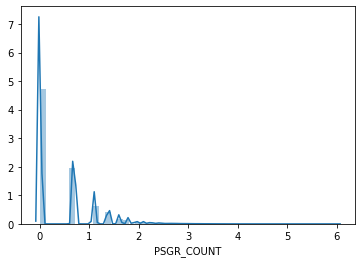

In [47]:
sns.distplot(train_df["PSGR_COUNT"])
plt.savefig("presentation/psgr_count_log.png")

In [ ]:
params = {'objective': 'regression','metric': 'rmse','learning_rate': 0.05,'verbose': -1,'nthread':12,
          'num_leaves': 10, 'min_data': 50, 'max_depth': 10, 'num_leaves': 31, 'min_data_in_leaf': 50, 'feature_fraction': 0.8,'bagging_fraction': 0.8}

sub_preds, oof_preds, feature_importance = kfold_lightgbm(params,train_df,test_df,FEATS_EXCLUDED,9999)

Starting LightGBM. Train shape: (9056281, 25)
Training until validation scores don't improve for 200 rounds.
[1000]	train's rmse: 0.573752	valid's rmse: 0.582107
[2000]	train's rmse: 0.565026	valid's rmse: 0.579215
[3000]	train's rmse: 0.559084	valid's rmse: 0.577905
[4000]	train's rmse: 0.554415	valid's rmse: 0.57717
[5000]	train's rmse: 0.5509	valid's rmse: 0.576768
[6000]	train's rmse: 0.547738	valid's rmse: 0.576535
[7000]	train's rmse: 0.54492	valid's rmse: 0.576417
[8000]	train's rmse: 0.542218	valid's rmse: 0.576155
Early stopping, best iteration is:
[8398]	train's rmse: 0.541271	valid's rmse: 0.576122
Fold  1 -> rmse : 0.576122 -- mape : inf -- mae : 0.458200


In [50]:
oof_preds = np.exp(oof_preds)
sub_preds = np.exp(sub_preds)
train_df["PSGR_COUNT"] = np.exp(train_df["PSGR_COUNT"])

In [55]:
oof_preds = np.where(oof_preds<1,1,oof_preds)
sub_preds = np.where(sub_preds<1,1,sub_preds)
final_rmse = sqrt(mean_squared_error(train_df['PSGR_COUNT'], oof_preds))
final_mape = mape(train_df['PSGR_COUNT'], oof_preds) 
final_mae = mean_absolute_error(train_df['PSGR_COUNT'], oof_preds)
print('Final rmse : %.6f -- mape : %.6f -- mae : %.6f' % (final_rmse,final_mape,final_mae)) 

Final rmse : 2.727973 -- mape : 0.454435 -- mae : 1.086484
